In [ ]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs, process_img
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches


import warnings
from astropy.wcs import FITSFixedWarning

# Suppress just FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)

In [2]:
from isolate_galaxy_mask import get_isolate_galaxy_mask, make_custom_cmap
%load_ext autoreload
%autoreload 2
    
cmap_cstm = make_custom_cmap(8, cmap_name="tab10")



In [13]:
from sga_nsa_comp_funcs import collect_sga_mags, make_compare_plot, plot_sga

In [4]:
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")
sga_cat = sga_cat[sga_cat["SHRED_MASKBIT"] == 0]




In [5]:
sga_mags_all, sga_aper_mags_all, sga_trac_mags_all, ff_all = collect_sga_mags(sga_cat)


In [7]:
make_compare_plot(sga_mags_all[2], sga_aper_mags_all[2], ylabel_top =r"mag$_{\rm SGA}$- mag$_{\rm aper}$", 
                      ylabel_bot = r"mag$_{\rm SGA}$", save_path = "plots/sga_all_compare_z_band.png",
                      title = "Comparison with SGA-2020 z-band",band_name = "z-band")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


140


In [8]:
match_tgids = [39628138115762807, 39628242226776575, 39628343561161817, 39628376708745386]
better_tgids =  [39627761270130297, 39627719486473819, 39632976304146316, 39627873182548501]
worse_tgids = [ 39633324834032193, 39627915440163235, 39633489556931574, 39627696413606604 ]

In [9]:
index = np.where(sga_cat["TARGETID"] == worse_tgids[3])[0][0]
sga_cat[index]["COG_MAXAPER_FRAC_IN"]

0.728151713527746

In [15]:
output_dir = "/pscratch/sd/v/virajvm/trash/sga_outlier_VI"
for i in range(4):
    fig,ax=make_subplots(ncol=3,nrow = 1, col_spacing = 0.05,return_fig=True)
    tgidi = worse_tgids[i]
    index = np.where(sga_cat["TARGETID"] == tgidi)[0][0]
    plot_sga(ax,sga_cat,index,scale_f=4,plot_isolate=False)
    outfile = os.path.join(output_dir, f"sga_index_worse_{tgidi}.png")
    fig.savefig(outfile, bbox_inches="tight")
    plt.close()

In [16]:
worse_tgids = sga_cat[np.abs(sga_mags_all[1] - sga_aper_mags_all[1]) > 0.75]["TARGETID"].data

print(len(worse_tgids))

102


In [175]:
output_dir = "/pscratch/sd/v/virajvm/trash/sga_outlier_VI"

all_files = []

for tgidi in worse_tgids:
    fig,ax=make_subplots(ncol=4,nrow = 1, col_spacing = 0.05,return_fig=True)
    index = np.where(sga_cat["TARGETID"] == tgidi)[0][0]
    plot_sga(ax,sga_cat,index,scale_f=4,plot_isolate=True)
    outfile = os.path.join(output_dir, f"sga_index_{tgidi}.png")
    fig.savefig(outfile, bbox_inches="tight")
    all_files.append(outfile)
    plt.close()

get_scrollable_pdfs(all_files,"/pscratch/sd/v/virajvm/trash/sga_VI_outliers.pdf")

Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/sga_VI_outliers.pdf


In [75]:
sga_faint = sga_cat[(sga_cat["MAG_R_APERTURE_COG"] > 15) & (sga_cat["FRACFLUX_R"] < 0.2)]

In [76]:
# all_trac = np.concatenate( [ sga_faint["MAG_G"].data, sga_faint["MAG_R"].data, sga_faint["MAG_Z"].data  ] )
# all_trac_my =  np.concatenate( [ sga_faint["MAG_G_APERTURE_COG"].data - sga_faint["MAG_G"].data, sga_faint["MAG_R_APERTURE_COG"].data - sga_faint["MAG_R"].data, sga_faint["MAG_Z_APERTURE_COG"].data - sga_faint["MAG_Z"].data] )
# all_trac_sga = np.concatenate( [ sga_faint["SGA_G_COG_MAG"].data - sga_faint["MAG_G"].data, sga_faint["SGA_R_COG_MAG"].data - sga_faint["MAG_R"].data, sga_faint["SGA_Z_COG_MAG"].data - sga_faint["MAG_Z"].data ] ) 

from desi_lowz_funcs import get_contours

cont_my = get_contours(sga_faint["MAG_R"].data, sga_faint["MAG_R_APERTURE_COG"].data - sga_faint["MAG_R"].data , bins = np.arange(15,19,0.25),sigs=True)
cont_sga = get_contours(sga_faint["MAG_R"].data,sga_faint["SGA_R_COG_MAG"].data - sga_faint["MAG_R"].data, bins = np.arange(15,19,0.25),sigs=True)


In [89]:
fig,ax = make_subplots(ncol=1,nrow=1,return_fig=True)

ax[0].set_title(r"FRACFLUX < 0.2",fontsize = 13)
ax[0].plot(cont_sga["bin_cents"],cont_sga["median"],color = "darkorange")
ax[0].fill_between(x = cont_sga["bin_cents"],y1=cont_sga["sig1_low"], y2=cont_sga["sig1_high"],color = "darkorange",alpha=0.4,label =  r"mag$_{\rm SGA}$")
# ax[0].fill_between(x = cont_sga["bin_cents"],y1=cont_sga["sig2_low"], y2=cont_sga["sig2_high"],color = "darkorange",alpha=0.2)


ax[0].plot(cont_my["bin_cents"],cont_my["median"],color = "mediumblue")
ax[0].fill_between(x = cont_my["bin_cents"],y1=cont_my["sig1_low"], y2=cont_my["sig1_high"],color = "mediumblue",alpha=0.4,label = r"mag$_{\rm aper}$ (this work)")
# ax[0].fill_between(x = cont_my["bin_cents"],y1=cont_my["sig2_low"], y2=cont_my["sig2_high"],color = "mediumblue",alpha=0.2)

ax[0].set_ylim([-0.6,0.4])

ax[0].axhline(y = 0, color = "k",lw = 1,ls = "--")

ax[0].set_xlim([15.75,18.5])

ax[0].legend(frameon=False,fontsize = 12,loc = "lower left")

ax[0].set_xlabel(r"Tractor, mag$_{r,\rm DR9}$",fontsize = 15)
ax[0].set_ylabel(r"mag$_{r,\rm DR9}$ - mag$_{r,\rm X}$",fontsize = 15)

plt.savefig("plots/sga_vs_my_method_clean_comp.pdf",bbox_inches="tight")

plt.close()



In [93]:
bgsb_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")

tot_shred = vstack([ bgsb_shred, bgsf_shred, lowz_shred, elg_shred ])

tot_shred = tot_shred[tot_shred["SHRED_MASKBIT"] == 0]

In [18]:
#also read in the nsa catalog
nsa_cat = Table.read("/pscratch/sd/v/virajvm/catalog/nsa_v1_0_1.fits")


In [29]:
from sga_nsa_comp_funcs import get_nsa_matching, plot_nsa

In [24]:
nsa_mag_all, desi_match_mag_all, nsa_trac_mag, nsa_ff_all, desi_nsa_match, nsa_match = get_nsa_matching(nsa_cat, tot_shred)
 



49060
38510
5389
5230


/global/u1/v/virajvm/galaxy_image_prior/paper_1/sga_nsa_comp_funcs.py:380: RuntimeWarning: invalid value encountered in log10
  nsa_petro_zmag = 22.5 - 2.5*np.log10(nsa_petro_zflux)


In [25]:
len(nsa_mag_all)

3

In [26]:

make_compare_plot(nsa_mag_all[0], desi_match_mag_all[0], ylabel_top =r"mag$_{\rm NSA}$ - mag$_{\rm aper}$", ylabel_bot = r"mag$_{\rm NSA}$",
                 save_path = "plots/nsa_clean_compare_only_g.png", title = "Comparison with NSA g-band",band_name = "g-band")

make_compare_plot(nsa_mag_all[1], desi_match_mag_all[1], ylabel_top =r"mag$_{\rm NSA}$ - mag$_{\rm aper}$", ylabel_bot = r"mag$_{\rm NSA}$",
                 save_path = "plots/nsa_clean_compare_only_r.png", title = "Comparison with NSA r-band",band_name = "r-band")

make_compare_plot(nsa_mag_all[2], desi_match_mag_all[2], ylabel_top =r"mag$_{\rm NSA}$ - mag$_{\rm aper}$", ylabel_bot = r"mag$_{\rm NSA}$",
                 save_path = "plots/nsa_clean_compare_only_z.png", title = "Comparison with NSA z-band",band_name = "z-band")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


177


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


183


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


318


In [27]:
nsa_bad_tgids_paper = [39627658979442966, 39627709944432012, 39627663320547970, 39627643640878867, 39627793792766271, 39627889687135617, 39627503219771992, 39627672954867965, 39627720946092125, 39627733398983952, 39627739707214817, 39627745226918247]
nsa_good_tgids_paper = [39627702776366521, 39627708736475750, 39627708749055631,39627601450375402,39627670568313160    ]
nsa_better_tgids_paper = [39633207930390678, 39628459877597639, 39627945148416047, 39627936113885462, 39627652578936400 ]



In [31]:
output_dir = "/pscratch/sd/v/virajvm/trash/nsa_VI"
for i in range(len(nsa_better_tgids_paper)):
    targetid = nsa_better_tgids_paper[i]
    fig,ax=make_subplots(ncol=3,nrow = 1, col_spacing = 0.05,return_fig=True)
    plot_nsa(ax,nsa_match,desi_nsa_match,targetid,scale_f=6,plot_isolate=False)
    outfile = os.path.join(output_dir, f"nsa_index_better_{targetid}.png")
    fig.savefig(outfile, bbox_inches="tight")
    plt.close()

In [32]:
desi_nsa_match_out = desi_nsa_match[np.abs(delta_mag_r) > 0.75]
nsa_match_out = nsa_match[np.abs(delta_mag_r) > 0.75]
print(len(nsa_match_out))

NameError: name 'delta_mag_r' is not defined

In [33]:
# from tqdm.notebook import trange
# output_dir = "/pscratch/sd/v/virajvm/trash/nsa_VI"

# all_files = []

# for index in trange(len(desi_nsa_match_out)):
#     targetid = desi_nsa_match_out["TARGETID"][index]
#     try:
#         fig,ax=make_subplots(ncol=4,nrow = 1, col_spacing = 0.05,return_fig=True)
    
#         plot_nsa(ax,nsa_match_out,desi_nsa_match_out,targetid,scale_f=6,plot_isolate=False)
        
#         outfile = os.path.join(output_dir, f"nsa_index_bad_{targetid}.png")
#         fig.savefig(outfile, bbox_inches="tight")
#         all_files.append(outfile)
#         plt.close()
#     except:
#         print(f"ERROR IN {targetid}")

# # from desi_lowz_funcs import get_scrollable_pdfs

# # get_scrollable_pdfs(all_files, "/pscratch/sd/v/virajvm/trash/nsa_outlier_VI.pdf")

In [34]:
from sga_nsa_comp_funcs import get_nsa_bias_panels

In [35]:
nsa_faint_bias = desi_nsa_match[(desi_match_mag_all[1] > 18) & (desi_match_mag_all[1] - nsa_mag_all[1] < -0.5 )]



In [36]:
# nsa_mag_all, desi_match_mag_all, nsa_trac_mag, nsa_ff_all, desi_nsa_match, nsa_match

faint_bias_tgids = nsa_faint_bias["TARGETID"].data

In [52]:
output_dir = "/pscratch/sd/v/virajvm/trash/nsa_VI"
all_files = []
for i in trange(len(faint_bias_tgids)):
    
    fig,ax = make_subplots(ncol =2, nrow = 1, col_spacing=0,return_fig=True)
    get_nsa_bias_panels(ax, faint_bias_tgids[i], desi_nsa_match, nsa_match )

    outfile = os.path.join(output_dir, f"nsa_bias_{faint_bias_tgids[i]}.png")
    fig.savefig(outfile, bbox_inches="tight")
    all_files.append(outfile)
    plt.close()


from desi_lowz_funcs import get_scrollable_pdfs

get_scrollable_pdfs(all_files, "/pscratch/sd/v/virajvm/trash/nsa_bias_VI.pdf")

/global/u1/v/virajvm/galaxy_image_prior/paper_1/sga_nsa_comp_funcs.py:653: UserWarning: Warning: converting a masked element to nan.
  im = ax[1].imshow(rgb_img, origin='lower')
100%|██████████| 142/142 [00:29<00:00,  4.82it/s]


Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/nsa_bias_VI.pdf


In [54]:
bias_tgids_paper = [39627929444942465, 39628476524795578, 39633153685455281, 2714898979094537, 39627697294412009, 39627697306992959, 39627702830895286, 39627703179023326, 39627703279686739, 39627709080405649, 39627709839576960, 39627715367671038, 39627715489302746, 39627720946092125, 39627720988034780, 39627726834896735, 39627726935558869, 39627727908635708]

output_dir = "/pscratch/sd/v/virajvm/trash/nsa_bias_paper"

for i in trange(len(bias_tgids_paper)):
    fig,ax = make_subplots(ncol =2, nrow = 1, col_spacing=0,return_fig=True)
    get_nsa_bias_panels(ax, bias_tgids_paper[i], desi_nsa_match, nsa_match )
    outfile = os.path.join(output_dir, f"nsa_bias_{faint_bias_tgids[i]}.png")
    fig.savefig(outfile, bbox_inches="tight")
    all_files.append(outfile)
    plt.close()



100%|██████████| 18/18 [00:03<00:00,  5.25it/s]


Documenting some of the NSA failure modes:

1) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190m005-200p000/1938m035/BGS_BRIGHT_tgid_39627703434871529 -> very LSB galaxy

2) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200m005-210p000/2066m032/BGS_BRIGHT_tgid_39627709680192992 -> edge of color color criterion and bright part is removed .. could be measured correctly in just isolate mask, but unclear how to flag those??

3) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200m005-210p000/2099m032/BGS_BRIGHT_tgid_39627709734717992 -> missing data!! The updated mask after masking does not have large fraction masked, but the original apeture does! We should include another maskbit that accounts for this

4) '/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-010m005-020p000/0193m020/BGS_BRIGHT_tgid_39627736733456748' -> cutout is under-estimating the photometry, ~0.47 is in of image, and our cutout is 0.25. Could be made more strict .. Found another object, so probably good to increase it to 0.5

5) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150m005-160p000/1536m020/BGS_BRIGHT_tgid_39627738985794946 -> another example of decreasing COG MAG, max len = 4 over 0.1 mag. Could this also be made more strict?? This will be fixed by isolate object!!

6) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-030p000-040p005/0336p015/BGS_BRIGHT_tgid_39627821529697854: some red components have been removed ... isolate object will get this better ...

7) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140p000-150p005/1496p017/BGS_BRIGHT_tgid_39627829515651432 -> this is example of object that hit the prior wall of COG mag, we need to. The purely tractor model reconstruction should be good here!! 

8) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-030p005-040p010/0345p062/BGS_BRIGHT_tgid_39627936113885462: -> another very LSB galaxy

9) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140p005-150p010/1456p070/BGS_BRIGHT_tgid_39627955982306238 -> edge color cut effect: the isolate galaxy mask should get this right, but how do we identify this ...

10) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150p005-160p010/1534p070/BGS_BRIGHT_tgid_39627956112331676': -> THE MODEL IS GOOD, BUT WE NEED TO MAKE THE APERTURE BETTER, ESSENTIALLY CHOOSE A VERY SMOOTH ONE AND CHOOSE THE LARGEST SEGMENT AS JUST FOR APERTURE ... if we get more than two segments in that image then that is sus!!

11) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-010p015-020p020/0149p157/BGS_BRIGHT_tgid_39628161155075350: cog decreases slightly (~0.089 mag), and the isolate galaxy mask should work well here ...

12)  /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-110p020-120p025/1150p242/BGS_BRIGHT_tgid_39628355925968630 : another issue of binary color cut ... 


13) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/north/sweep-250p030-260p035/2593p335/BGS_BRIGHT_tgid_39632951931045849: another example where isoalted galaxywill work wella s it is red elliptical galaxy ... also the segment has two blobs suggesting also wrong stuff is happening!! Decrease in cog mag around 0.19

14) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/north/sweep-190p035-200p040/1984p352/BGS_BRIGHT_tgid_39632986047514506': another example where binary color cut and over subtraction happens, cog decrease of 0.09 mag. be well fixed by isolate mask ... 

## WE HAVE GOOD MODELS:
 
1)  /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-180m005-190p000/1896m005/BGS_BRIGHT_tgid_39627775828559637: blue dwarf thigny

2)  /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-210m005-220p000/2123m002/BGS_BRIGHT_tgid_39627782250039256: blue dwarf thingy

3) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-310m005-320p000/3173p000/BGS_BRIGHT_tgid_39627790051447101: two blended objects and we get them right!!

4) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190p000-200p005/1963p012/BGS_BRIGHT_tgid_39627818220393469: another blue dwarf thi

5) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220p000-230p005/2261p017/BGS_BRIGHT_tgid_39627830799106947: blended object! we get consistent photometry with tractor so that is good

6) /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-130p030-140p035/1355p322/BGS_BRIGHT_tgid_39628526722223954: another blue dwarf that we get right?

In [76]:
from shred_photometry_maskbits import large_frac_cog_aper_out

In [78]:
large_frac_cog_aper_out(desi_nsa_match[ delta_mag_r < -0.75 ][:5])

masked_array(data=[False, False, False, False, False],
             mask=False,
       fill_value=1e+20)

In [131]:
desi_nsa_match[ delta_mag_r < -0.75][26]["FILE_PATH"] #["COG_DECREASE_MAX_MAG"]

'/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/north/sweep-230p035-240p040/2388p352/BGS_BRIGHT_tgid_39632986601163305'

In [126]:
delta_mag_r[ delta_mag_r < -0.75][25]

-1.7513920870515065

In [102]:
def make_fracflux_compare_plot(all_fracs, new_mags, tractor_mags, ext_mags, title = "Comparison with SGA-2020 after cleaning",
              ylab_top = r"mag$_{\rm aper}$ - mag$_{\rm DR9}$", ylab_bot=r"mag$_{\rm aper}$ - mag$_{\rm SGA}$", 
           save_path = "plots/sga_trac_ff_comp.png"):
    
    ax = make_subplots(ncol = 1, nrow = 2, row_spacing = 0.3)

    if title is not None:
        ax[1].set_title(title,fontsize = 15)
    
    bins = 50

    all_dms = new_mags - tractor_mags
    
    all_dms_v2 = new_mags - ext_mags
    
    im = ax[1].hist2d( all_fracs, all_dms,
                 range=( (1e-2,5), (-5,0.5) ), bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],
                 norm=LogNorm(vmin=1,vmax=150),cmap = cmr.dusk_r, rasterized=True)
    
    im = ax[0].hist2d( all_fracs, all_dms_v2,
                 range=( (1e-2,5), (-5,0.5) ), bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],
                 norm=LogNorm(vmin=1,vmax=150),cmap = cmr.dusk_r,rasterized=True)


    for i in range(2):
        ax[i].set_xlim([1e-2,5])
        ax[i].set_ylim([-5,2])
        ax[i].set_xscale("log")
        ax[i].hlines(y = 0,xmin=1e-2, xmax = 5,ls = "-",color = "grey",lw =1 )
        ax[i].vlines(x = 0.2, ymin = -5, ymax = 2, color= "grey", ls = "--",lw = 1)
        ax[0].set_xlabel(r"FRACFLUX",fontsize = 15)
        ax[1].set_ylabel(ylab_top,fontsize = 15)
        ax[0].set_ylabel(ylab_bot, fontsize = 15)

    #insert a colorbar
    colbar_x, colbar_y = 0.0775, 0.08
    
    cbar = plt.colorbar(im[3], ax=ax[1], orientation='horizontal', pad=0.05)
    cbar.ax.set_position([
    colbar_x,   # Left position
    colbar_y,  # Top position
    ax[1].get_position().width * 0.065,  # Width (40% of plot width)
    0.015  # Height (thin bar)
    ])

    ax[1].set_xticklabels([])
    
    plt.savefig(save_path,bbox_inches="tight")
    plt.show()
    return


In [95]:
sga_trac_all = np.concatenate(sga_trac_mags_all)
sga_sga_mags_all = np.concatenate(sga_mags_all)
sga_aper_all = np.concatenate(sga_aper_mags_all)



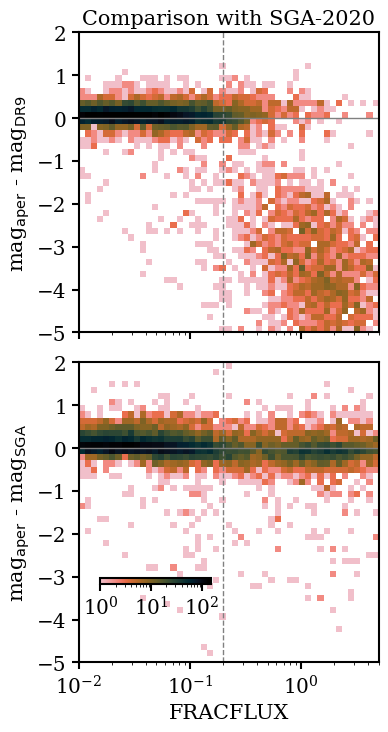

In [103]:
make_fracflux_compare_plot(ff_all, sga_aper_all, sga_trac_all, sga_sga_mags_all, title = "Comparison with SGA-2020",
              ylab_top = r"mag$_{\rm aper}$ - mag$_{\rm DR9}$", ylab_bot=r"mag$_{\rm aper}$ - mag$_{\rm SGA}$", 
           save_path = "plots/sga_trac_ff_comp.pdf")



In [99]:
nsa_nsa_mag_all = np.concatenate(nsa_mag_all)
nsa_trac_all = np.concatenate(nsa_trac_mag)
nsa_aper_all = np.concatenate(desi_match_mag_all)


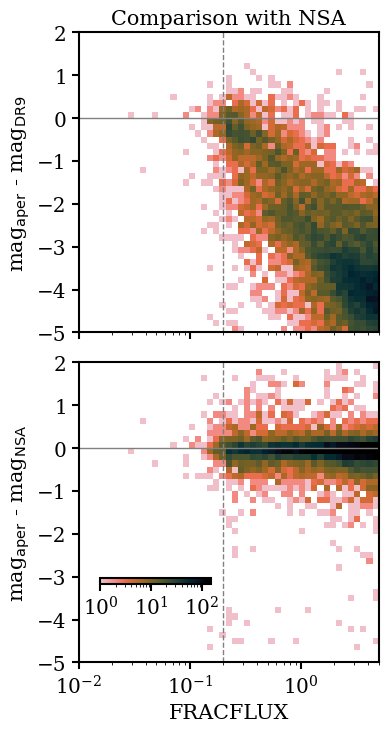

In [104]:
make_fracflux_compare_plot(nsa_ff_all, nsa_aper_all, nsa_trac_all, nsa_nsa_mag_all, title = "Comparison with NSA",
              ylab_top = r"mag$_{\rm aper}$ - mag$_{\rm DR9}$", ylab_bot=r"mag$_{\rm aper}$ - mag$_{\rm NSA}$", 
           save_path = "plots/nsa_trac_ff_comp.pdf")



Comparison with the 50MGC catalog

In [106]:
mgc_data = Table.read("/global/homes/v/virajvm/galaxy_image_prior/paper_1/datasets/catalog_50MPC.fits")
mgc_data_no_sga = mgc_data[(mgc_data["sga_obj"] == 0)] # & (mgc_data["nsa_obj"] == 1)
#we want to make a comparison that is not in SGA 
print(len(mgc_data))
print(len(tot_shred))

15424
38510


In [107]:
idx, d2d,_ = match_c_to_catalog(c_cat = mgc_data_no_sga, catalog_cat = tot_shred, c_ra="ra",c_dec="dec")

In [111]:
##as there is no radius information in the catalog, we simply adopt a 10 arcsec distance cutoff
mgc_match = mgc_data_no_sga[d2d.arcsec < 20]
desi_mgc_match = tot_shred[idx][d2d.arcsec < 20]
print(len(mgc_match))
np.unique(mgc_match["mag_flag"] )

136


0
1
2


In [113]:
from sga_nsa_comp_funcs import get_50mgc_Bmag
import cmasher as cmr
bmags_mgc = get_50mgc_Bmag(mgc_match)
desi_Bmag = desi_mgc_match["MAG_G_APERTURE_COG"].data + 0.39*(desi_mgc_match["MAG_G_APERTURE_COG"].data - desi_mgc_match["MAG_R_APERTURE_COG"].data) + 0.21



23
136


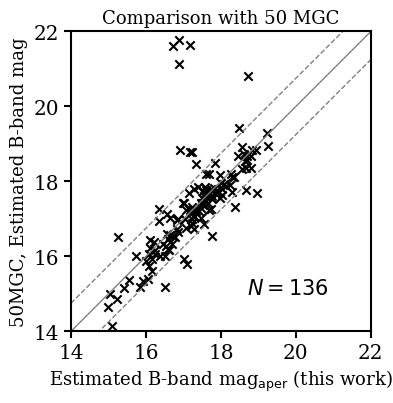

In [130]:
fig,ax = make_subplots(ncol = 1, nrow = 1,return_fig=True)

ax[0].set_title("Comparison with 50 MGC",fontsize = 13)

# im = ax[0].scatter(desi_Bmag,bmags_mgc,range=((14,22), (14,22)),bins=20,norm=LogNorm(vmin=1,vmax=20), cmap = cmr.dusk_r, zorder = 0 )
im = ax[0].scatter(desi_Bmag,bmags_mgc,color = "k",marker = "x",rasterized=True)

ax[0].plot([14,22],[14,22],color = "grey",zorder=1,lw = 1,rasterized=True)
ax[0].plot([14,22],[14-0.75,22-0.75],color = "grey",zorder=1, ls = "--",lw = 1,rasterized=True)
ax[0].plot([14,22],[14+0.75,22+0.75],color = "grey",zorder=1,ls = "--",lw = 1,rasterized=True)
ax[0].set_xlabel(r"Estimated B-band mag$_{\rm aper}$ (this work)",fontsize = 13)
ax[0].set_ylabel(r"50MGC, Estimated B-band mag",fontsize = 13)
ax[0].set_xlim([14,22])
ax[0].set_ylim([14,22])

delta_mag_mgc = bmags_mgc - desi_Bmag

print(len(delta_mag_mgc[np.abs(delta_mag_mgc) > 0.75]))
print(len(bmags_mgc))

ax[0].text(18.7,15,r"$N = %d$"%int(len(desi_Bmag)),fontsize = 15)
    
plt.savefig("plots/mag_compare_50MGC.pdf",bbox_inches="tight")
plt.show()

In [123]:
desi_mgc_match["DESI_B_MAG"] = desi_Bmag
desi_mgc_match["50MGC_B_MAG"] = bmags_mgc


In [135]:
tgids_mgc_paper = desi_mgc_match[(np.abs(delta_mag_mgc) > 1) & (desi_Bmag > 15)]["TARGETID"].data

In [132]:
# desi_mgc_match[desi_mgc_match["TARGETID"] == 39628124182286640]["FILE_PATH"]

In [147]:
## make a plot of the grz image and our reconstruction, 50MGC B band, and our reconstruction with apeture plotted
## focus on those with 1 mag or higher discrepancy 

from sga_nsa_comp_funcs import plot_50mgc_compare


output_dir = "/pscratch/sd/v/virajvm/trash/mgc50_VI"
all_files = []
for i in trange(len(tgids_mgc_paper)):
    
    fig,ax = make_subplots(ncol =2, nrow = 1, col_spacing=0,return_fig=True)
    plot_50mgc_compare(ax, desi_mgc_match,tgids_mgc_paper[i])
    outfile = os.path.join(output_dir, f"mgc_out_{tgids_mgc_paper[i]}.png")
    fig.savefig(outfile, bbox_inches="tight")
    all_files.append(outfile)
    plt.close()

from desi_lowz_funcs import get_scrollable_pdfs

get_scrollable_pdfs(all_files, "/pscratch/sd/v/virajvm/trash/mgc_out_VI.pdf")

# 

100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/mgc_out_VI.pdf


In [148]:
mgc_match[(np.abs(delta_mag_mgc) > 1) & (desi_Bmag > 15)]

objname,pgc,nsaid,specobjid,plate,fiberid,mjd,group_id,ra,dec,ra_nsa,dec_nsa,ra_ned,dec_ned,d25,v_h,v_cmb,v_source,hl_obj,lvg_obj,nsa_obj,sga_obj,t_type,color_type,best_type,a_B_leda,a_g_nsa,EBV_irsa,Bt0_leda,BV_color_leda,B_lum,gi_color_nsa,i_lum_nsa,gr_color_sga,r_lum_sga,BR_color_ned,R_lum_ned,BMag,gi_color,mag_flag,cf3_dist,cf3_dist_error,zind_dist,zind_dist_error,zind_indicator,bestdist,bestdist_error,bestdist_method,bestdist_source,dist_ned_flag,logmass_gi,logmass_gr,logmass_BV,logmass_BR,logmass,logmass_error,logmass_src,chandra_observation,chandra_detection,log_lx,chandra_detection_3arcsec,log_lx_3arcsec
bytes28,int32,int32,int64,int32,int16,int32,int32,float64,float64,float64,float64,float64,float64,float32,float32,float32,bytes3,uint8,uint8,uint8,uint8,float32,bytes6,bytes6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,float32,float32,float32,float32,bytes8,float32,float32,bytes12,int16,int16,float32,float32,float32,float32,float32,float32,bytes3,uint8,uint8,float32,uint8,float32
AGC227970,5059984,-1,-1,-1,-1,-1,-1,191.5058325,4.3811109,--,--,191.5075,4.37917,--,642.0,969.39,lvg,1,1,0,0,9.0,notype,late,0.09116,--,0.021,15.893,--,56760212.0,--,--,--,--,--,--,-13.94511,--,0,6.7720847,5.2841663,8.9,1.7739394,TF,8.9,1.774,Karachentsev,1,-1,--,--,--,--,--,--,--,0,0,--,0,--
PGC034501,34501,326806,1820700048342673408,1617,436,53112,-1,169.4416695,7.6386465,169.44164094,7.63895885,169.44126,7.63911,--,2712.35,3034.34,nsa,1,0,1,0,9.0,late,late,0.14964,0.13184,0.0341,15.322,--,2312783000.0,0.50789213,624688200.0,--,--,--,--,-17.970337,0.50789213,1,42.514732,4.651045,--,--,nan,42.515,4.651,CF3-Z,3,-1,8.471,--,--,--,8.471,0.136,g-i,1,0,--,0,--
PGC135803,135803,628370,-1,-1,-1,-1,-1,186.9429,1.5996,186.94176122,1.60022278,186.9429,1.60015,0.25703958,1292.0,971.48,nsa,1,0,1,0,9.7,late,late,0.07482,0.06525,0.0174,16.017,--,171433580.0,0.14494866,111196856.0,--,--,--,--,-15.14524,0.14494866,0,19.52347,8.741,--,--,nan,16.5,1.1,EVCC,0,-1,7.468,--,--,--,7.468,0.136,g-i,0,0,--,0,--
PGC1531600,1531600,516345,2804725584272320512,2491,396,53855,-1,167.057988,17.3894335,167.05639924,17.38958424,167.05803,17.38946,0.2630268,2942.1,2615.2,nsa,1,0,1,0,10.0,late,late,0.07224,0.06351,0.0166,18.845,--,97576184.0,0.4873476,341542620.0,--,--,--,--,-14.53336,0.4873476,2,45.837814,5.183856,--,--,nan,45.838,5.184,CF3-Z,3,-1,8.195,--,--,--,8.195,0.136,g-i,0,0,--,0,--
PGC2801034,2801034,-1,-1,-1,-1,-1,-1,258.175338,13.9077274,--,--,258.17529,13.90771,--,1502.1,1349.74,hyp,1,0,0,0,10.0,notype,late,0.57706,--,0.1336,17.128,--,145281710.0,--,--,--,--,--,--,-14.965528,--,0,20.10451,5.62531,--,--,nan,20.105,5.625,CF3-Z,3,-1,--,--,--,--,--,--,--,0,0,--,0,--
PGC2801040,2801040,-1,-1,-1,-1,-1,-1,272.71689,37.2479835,--,--,272.71686,37.248,--,1510.0,1850.5,hyp,1,0,0,0,10.0,notype,late,0.17372,--,0.0401,17.497,--,90139110.0,--,--,--,--,--,--,-14.447283,--,0,22.600218,4.1858883,--,--,nan,22.6,4.186,CF3-Z,3,-1,--,--,--,--,--,--,--,0,0,--,0,--
PGC3080142,3080142,-1,-1,-1,-1,-1,-1,39.701115,0.5202006,--,--,39.70249,0.52019,--,1460.3,1783.18,hyp,1,0,0,0,10.0,notype,late,0.14362,--,0.0335,16.649,--,104442020.0,--,--,--,--,--,--,-14.607188,--,0,16.692202,5.8254523,--,--,nan,16.692,5.825,CF3-Z,3,-1,--,--,--,--,--,--,--,0,0,--,0,--
PGC3257206,3257206,-1,-1,-1,-1,-1,-1,148.39935,-5.1178,--,--,148.39919,-5.11807,--,3058.0,3382.71,hyp,1,0,0,0,--,notype,notype,0.14276,--,0.0329,17.844,--,270388000.0,--,--,--,--,--,--,-15.639969,--,0,46.58453,5.4245048,--,--,nan,46.585,5.425,CF3-Z,3,-1,--,--,--,--,--,--,--,1,0,--,0,--
PGC3269460,3269460,-1,-1,-1,-1,-1,-1,192.72045,-4.1572,--,--,192.7205,-4.15733,--,1469.0,1168.21,hyp,1,0,0,0,10.0,notype,late,0.09632,--,0.0221,18.878,--,20965024.0,--,--,--,--,--,--,-12.863738,--,0,21.33456,8.44024,--,--,nan,21.335,8.44,CF3-Z,3,-1,--,--,--,--,--,--,--,0,0,--,0,--
